# <span style="color:red">图像预处理过程<span>
<span style="color:blue">
这个过程可以总结为抠图过程——就是在一副图像中，提取出车牌号的那一块出来，这纯粹就是个图像处理的过程；对于抠出来的图片，还通过SVM判断器分析是否是车牌图像，可以在减少后续OCR操作的同时，也增加了识别的准确率。

<span style="color:blue">
(1) 高斯模糊化，可以平滑滤除小的变化细节，保留车牌边沿这些大的细节；

<span style="color:blue">
(2) 图片灰度化；

<span style="color:blue">
(3) 对图像X轴方向做Sobel计算（等于是个求导操作），求取图像变化特征，至于为何只求水平方向而不求垂直方向，作者用实验的方法表明，水平方向Sobel足以获得足够的特征用于后续求取轮廓，而垂直Sobel计算往往对最终结果有害无益；

<span style="color:blue">
(4) OTSU法自适应对图像进行二值化（一看就是日本名字，经典啊）；

<span style="color:blue">
(5) 进行形态学的膨胀腐蚀操作，滤除小的噪声点，同时获取相应的连通区域；

<span style="color:blue">
(6) 求取Contours轮廓，同时对轮廓进行粗筛选（比如角度、大小、长宽比等）；

<span style="color:blue">
(7) SVM判别器分析图像块是否为含车牌图像；
<span>

# <span style="color:red">(1) 高斯模糊化，可以平滑滤除小的变化细节，保留车牌边沿这些大的细节；<span>

导入库

In [43]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

导入图像文件

In [48]:
def imshow(img, cmap=None):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.imshow(img, cmap=cmap)
    plt.show()

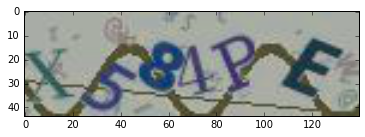

In [49]:
img = cv2.imread('sample/yanzhengma521.png')
imshow(img)

# 均值模糊

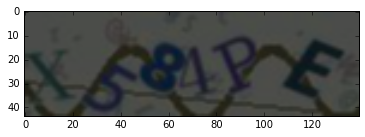

In [50]:
kernel = np.ones((2, 2), np.float32) / 9
dst = cv2.filter2D(img, -1, kernel)
imshow(dst)

# 高斯模糊

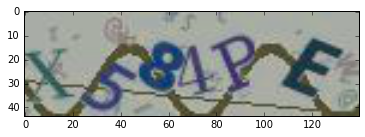

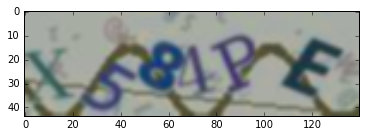

In [51]:
blur = cv2.GaussianBlur(img, (3, 3), 0)
imshow(img)
imshow(blur)

# 双边模糊

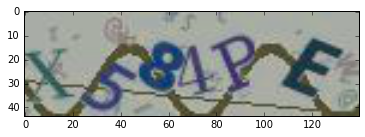

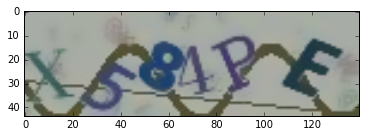

In [37]:
blur = cv2.bilateralFilter(img, 9, 75, 75)
imshow(img)
imshow(blur)

# 中值模糊

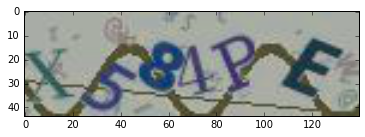

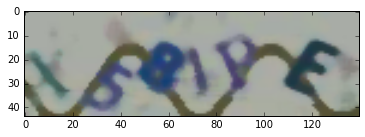

In [38]:
median = cv2.medianBlur(img,5)
imshow(img)
imshow(median)

# 显然高斯模糊和双边模糊的效果最好

# <span style="color:red">(2) 图片灰度化；<span>

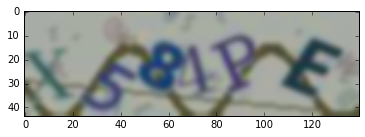

In [45]:
img = cv2.GaussianBlur(img, (3, 3), 0)
imshow(img)

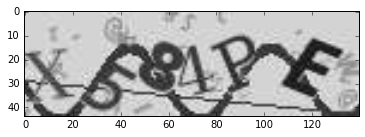

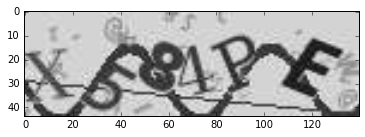

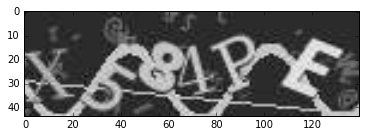

In [53]:
grayimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
imshow(grayimg, 'gray')
imshow(grayimg, plt.cm.gray)
imshow(grayimg, plt.cm.gray_r)

# <span style="color:red">(3) 对图像X轴方向做Sobel计算<span>

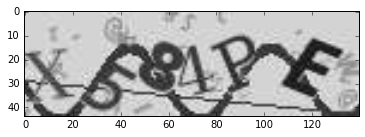

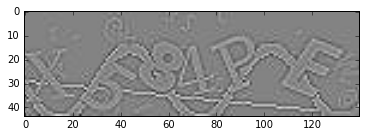

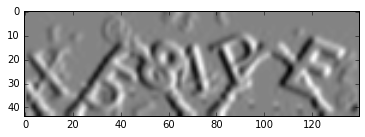

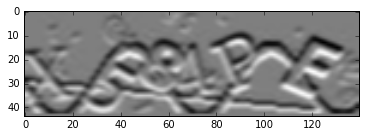

In [62]:
laplacian = cv2.Laplacian(grayimg,cv2.CV_64F)
sobelx = cv2.Sobel(grayimg,cv2.CV_64F,1,0,ksize=5)
sobely = cv2.Sobel(grayimg,cv2.CV_64F,0,1,ksize=5)
imshow(grayimg, 'gray')
imshow(laplacian, 'gray')
imshow(sobelx, 'gray')
imshow(sobely, 'gray')

In [77]:
print grayimg.shape
print sobely.max()
print sobely.min()

(44L, 140L)
5527.0
-5469.0


# <span style="color:red">(4) OTSU法自适应对图像进行二值化<span>

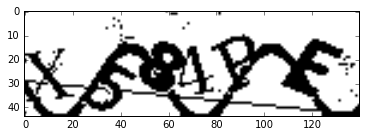

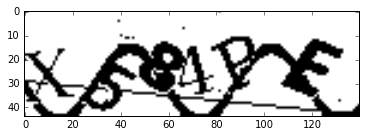

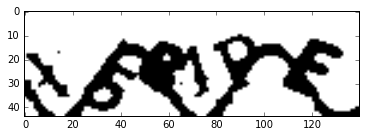

In [59]:
# global thresholding
ret1,th1 = cv2.threshold(grayimg,127,255,cv2.THRESH_BINARY)
# Otsu's thresholding
ret2,th2 = cv2.threshold(grayimg,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
# Otsu's thresholding after Gaussian filtering
blur = cv2.GaussianBlur(grayimg,(5,5),0)
ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
imshow(th1, 'gray')
imshow(th2, 'gray')
imshow(th3, 'gray')

# <span style="color:red">(5) 进行形态学的膨胀腐蚀操作，滤除小的噪声点，同时获取相应的连通区域；<span>

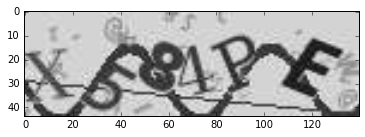

In [78]:
imshow(grayimg, 'gray')

灰度反转

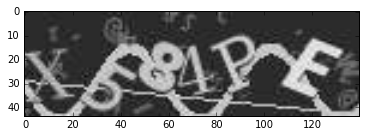

In [84]:
grayimg_inv = 255 - grayimg
imshow(grayimg_inv, 'gray')

腐蚀

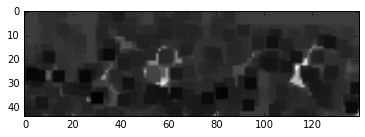

In [85]:
kernel = np.ones((5,5),np.uint8)
erosion = cv2.erode(grayimg_inv,kernel,iterations = 1)
imshow(erosion, 'gray')

看样子，如果要进行腐蚀处理的话得先二值化，先进行高斯的二值化看看效果

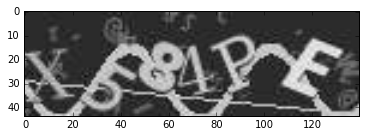

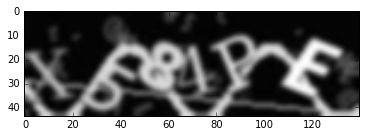

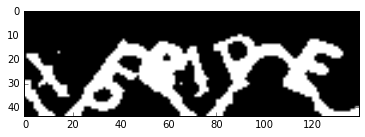

In [87]:
blur = cv2.GaussianBlur(grayimg_inv,(5,5),0)
ret3,grayimg_inv_b = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
imshow(grayimg_inv, 'gray')
imshow(blur, 'gray')
imshow(grayimg_inv_b, 'gray')

效果不行，看看普通的二值化、和OTSU二值化

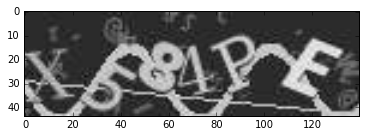

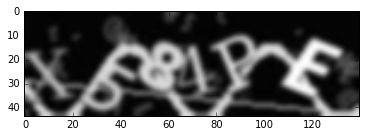

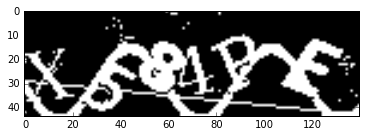

In [88]:
ret1,grayimg_inv_b = cv2.threshold(grayimg_inv,127,255,cv2.THRESH_BINARY)
imshow(grayimg_inv, 'gray')
imshow(blur, 'gray')
imshow(grayimg_inv_b, 'gray')

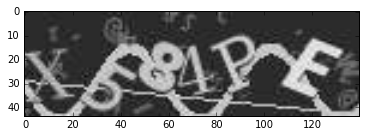

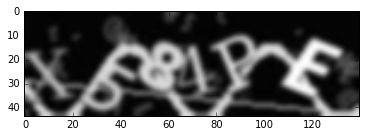

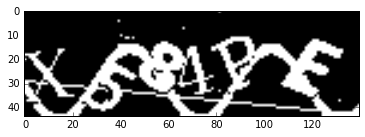

In [90]:
ret1,grayimg_inv_b = cv2.threshold(grayimg_inv,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
imshow(grayimg_inv, 'gray')
imshow(blur, 'gray')
imshow(grayimg_inv_b, 'gray')

OTSU二值化效果最好，我们再做腐蚀操作

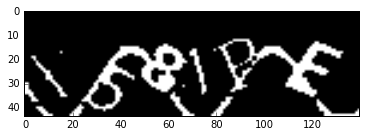

In [101]:
kernel = np.ones((2,2),np.uint8)
erosion = cv2.erode(grayimg_inv_b,kernel,iterations = 1)
imshow(erosion, 'gray')

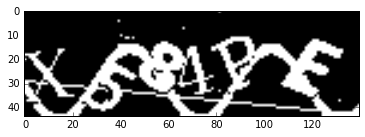

In [100]:
kernel = np.ones((1,1),np.uint8)
erosion = cv2.erode(grayimg_inv_b,kernel,iterations = 1)
imshow(erosion, 'gray')

膨胀操作

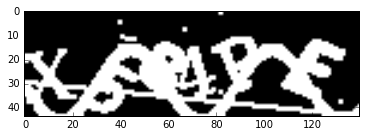

In [116]:
kernel = np.ones((2,2),np.uint8)
dilation = cv2.dilate(grayimg_inv_b,kernel,iterations = 1)
imshow(dilation, 'gray')

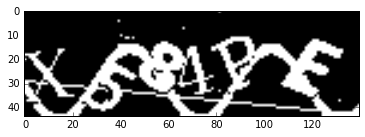

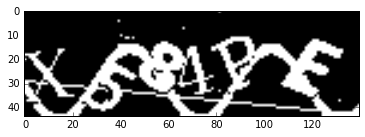

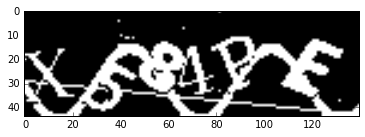

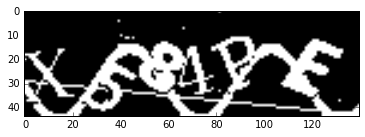

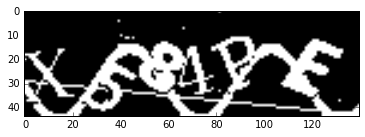

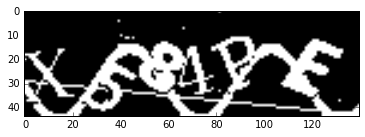

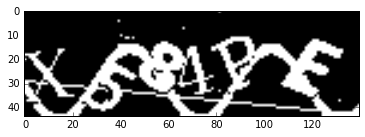

In [123]:
kernel = np.ones((1,1),np.uint8)
dilation = cv2.dilate(grayimg_inv_b,kernel,iterations = 2)
imshow(dilation, 'gray')
kernel = np.ones((1,1),np.uint8)
erosion = cv2.erode(dilation,kernel,iterations = 2)
imshow(erosion, 'gray')
kernel = np.ones((1,1),np.uint8)
dilation = cv2.dilate(erosion,kernel,iterations = 2)
imshow(dilation, 'gray')
kernel = np.ones((1,1),np.uint8)
erosion = cv2.erode(dilation,kernel,iterations = 2)
imshow(erosion, 'gray')
kernel = np.ones((1,1),np.uint8)
dilation = cv2.dilate(erosion,kernel,iterations = 2)
imshow(dilation, 'gray')
kernel = np.ones((1,1),np.uint8)
erosion = cv2.erode(dilation,kernel,iterations = 2)
imshow(erosion, 'gray')
kernel = np.ones((1,1),np.uint8)
dilation = cv2.dilate(erosion,kernel,iterations = 2)
imshow(dilation, 'gray')

<span style="color:green">去除噪点

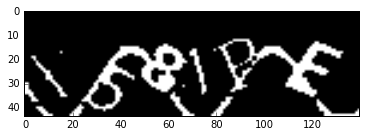

In [108]:
blur = cv2.GaussianBlur(erosion,(1,1),0)
ret3,mask = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
imshow(mask, 'gray')

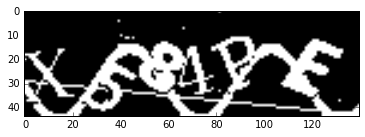

In [126]:
blur = cv2.GaussianBlur(dilation,(1,1),0)
ret3,mask = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
imshow(mask, 'gray')

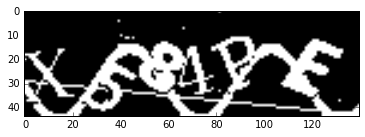

In [140]:
blur = cv2.GaussianBlur(blur,(1,1),0)
ret3,mask = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
imshow(mask, 'gray')

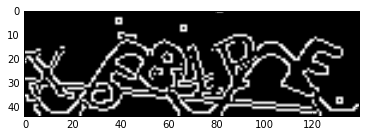

In [130]:
edges = cv2.Canny(erosion,100,200)
imshow(edges, 'gray')